<br>
<br>

![iteso](https://upload.wikimedia.org/wikipedia/en/5/5f/Western_Institute_of_Technology_and_Higher_Education_logo.png)

**InstitutoTecnológico y de Estudios Superiores de Occidente**

**Maestría Ciencia de Datos**

**Modelos Gráficos Probabilísticos**

<br>

* * *

Estudiante: Daniel Nuño <br>
Profesor: Dr. Esteban Jimenez <br>
Fecha entrega: 15 de julio, 2022<br>

* * *

<br>

# Análisis de retrasos de vuelos con red bayesiana


![aviones](https://upload.wikimedia.org/wikipedia/commons/c/c9/F-16_June_2008.jpg)

## Descripción del problema

Cuando viajas por aire es común que los vuelos sean retrasados o incluso sean cancelados. Podemos considerar el conjunto de aeropuertos como una gran red bayesiana, y en cada instancia sea un vuelo que depende del anterior, clima y otros factores específicos a la aerolínea, la aeronave o el trabajo y congestionamiento en terminal.

Los sistemas de transporte en red exhiben relaciones complejas y dinámicas entre los retrasos en los segmentos de transporte individuales y entre los factores que causan los retrasos. Las investigaciones han demostrado que estos retrasos son un fenómeno estocástico que es difícil de predecir con certeza, incluso a partir de información de aeronaves a nivel micro.

Dado que existe un vínculo entre los vuelos programados, cada retraso de vuelo programado puede afectar al aeropuerto downstream y a su vuelo programado. Por lo tanto, se necesitan métodos para investigar y visualizar la propagación de los retrasos en la conexión de vuelos en los aeropuertos centrales. La red bayesiana es un método efectivo para modelar análisis de propagación.

La predicción y el análisis de las causas de los retrasos han sido durante mucho tiempo importantes temas de investigación debido a su importancia crucial en la gestión del tráfico aéreo y la toma de decisiones de las aerolíneas. Este reporte se enfoca en la predicción de un retraso, retraso por más de los 15 minutos de la planeada salida, pero tener el modelo de la red aeroportuaria es puede ser útil para el análisis de dependencias de vuelos con retrasos concurrentes y así tomar decisiones.

Incluso como usuario final podrias determinar si la es mala idea volar con alguna aerolínea. O a como negocio tercerizar la venta de seguros para contratiempos de última hora. Una estimación de la Universidad de Berkeley estima un costo anual de $32.9b USD. De los cuales $8.3 es costo a la aerolínea y $16.7b costo a los pasajeros.


La red podría ser tan compleja, como que abarque vuelos internacionales que detallen la diferencia de horas y clima. Detalle no solo el aeropuerto si no también la terminal, puertas y el atraso esperado al tiempo de despegue y aterrizaje considerando las horas de vuelo y la resiliencia del aeropuerto. Detalle de la aeronave, tripulación y el equipo en el mantenimiento. La secuencia de los vuelos de conexión o el siguiente y previos vuelos de la aeronave.


Booz Allen Hamilton utiliza varias bases de datos con una hipótesis en especifica
- Causa del retraso, largo del retraso son indicadores importantes.
- Clima, y porcentaje de información a tiempo son indicadores de retraso.
- Decremento de la capacidad afecta los retrasos.
- Hay específicos al aeropuerto que indican retrasos.
- Edad, detalle del equipo están correlacionados con problemas mecánicos.

Como es muy complicado obtener toda esta información voy a utilizar una base de datos modesta de la Oficina de Estadística de Transporte del Gobierno de Estados Unidos.

## Propuesta solución

Estos datos se recopilan de la Oficina de Estadísticas de Transporte, Gobierno. de los EE.UU. Estos datos son de código abierto bajo el gobierno de EE. UU. Obras. Este conjunto de datos contiene todos los vuelos en el mes de enero de 2019. Hay más de 400,000 vuelos en el mes de enero en todo Estados Unidos. Las características se eligieron manualmente para hacer un análisis. Hay varias otras características disponibles en su sitio web. Kaggle January Flight Delay Prediction. (2020, April 14).

La solución propuesta es una red bayesiana que describa el conjunto de variables aleatorias y sus dependencias condicionales a través de un grafo acíclico dirigido y así inferir la probabilidad de que el vuelo sea retrasado o cancelado.

Este archivo contiene todos los vuelos desde el 1 de enero de 2019 hasta el 31 de enero de 2019. Hay alrededor de 400 000 filas en este archivo y 21 columnas de características que indican las características del vuelo, incluida información sobre el aeropuerto de origen, el aeropuerto de destino, la información del avión, la hora de salida y la llegada.

- Day of Month.
- Day of Week.
- Airline Code.
- Identification number assigned by US DOT to identify a unique airline.
- Code assigned by IATA.
- Tail Number.
- Flight Number.
- Origin Airport, Airport ID.
- Origin Airport, Airport Sequence ID.
- Origin Airport.
- Destination Airport, Airport ID.
- Destination Airport, Airport Sequence ID.
- Destination Airport.
- Actual Departure Time (local time: hhmm).
- Departure Delay Indicator, 15 Minutes or More (1=Yes, 0=No).
- Departure Time Block, Hourly Intervals.
- Actual Arrival Time (local time: hhmm).
- Arrival Delay Indicator, 15 Minutes or More (1=Yes, 0=No).
- Cancelled Flight Indicator (1=Yes, 0=No).
- Diverted Flight Indicator (1=Yes, 0=No).
- Distance between airports (miles).

Para mantener el análisis sencillo primero voy a seleccionar una aeronave y hacer el estudio basado en ella. Aunque necesito saber condiciones del origen y destino en general que no sean dependientes de la aeronave, como el congestionamiento del aeropuerto de salida y llegada, y el clima.

Como la pregunta que queremos resolver es la de ¿mi vuelo llegara tarde? entonces la variable que tendrá más peso es si ya se demoró para la salida.

### Análisis Exploratorio

In [1]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import math
import json
import numpy as np
import pandas as pd
import networkx as nx
#import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from IPython.display import Image
import missingno as msno
import seaborn as sns

In [2]:
data = pd.read_csv('Jan_2019_ontime.csv')
data.dtypes

DAY_OF_MONTH               int64
DAY_OF_WEEK                int64
OP_UNIQUE_CARRIER         object
OP_CARRIER_AIRLINE_ID      int64
OP_CARRIER                object
TAIL_NUM                  object
OP_CARRIER_FL_NUM          int64
ORIGIN_AIRPORT_ID          int64
ORIGIN_AIRPORT_SEQ_ID      int64
ORIGIN                    object
DEST_AIRPORT_ID            int64
DEST_AIRPORT_SEQ_ID        int64
DEST                      object
DEP_TIME                 float64
DEP_DEL15                float64
DEP_TIME_BLK              object
ARR_TIME                 float64
ARR_DEL15                float64
CANCELLED                float64
DIVERTED                 float64
DISTANCE                 float64
Unnamed: 21              float64
dtype: object

In [3]:
data.drop(columns=['Unnamed: 21'], inplace=True)

In [4]:
#prepare the data
df_carieer = pd.DataFrame(data['OP_CARRIER'].value_counts().reset_index().values, columns=["OP_CARRIER", "AggregateOP"])
# df_carieer = df_carieer.sort_index(axis = 0, ascending=True)
df_carieer= df_carieer.sort_values('AggregateOP',ascending=False)

fig = px.bar(df_carieer, y='AggregateOP', x='OP_CARRIER', text='AggregateOP', opacity = 0.8)
fig.update_traces(texttemplate='%{text:.1s}', textposition='outside')
fig.update_layout(uniformtext_minsize=4, uniformtext_mode='hide', title_x = 0.5,title_text='Carriers Count (OP Carrier)', yaxis=dict(title='Count'),
                  xaxis=dict(title='OP Carrier Code'))
fig.add_annotation( x='WN', y=100000, text="Highest OP CARRIER - WN",showarrow=True, font=dict( family="Courier New, monospace", size=10, color="#ffffff" ), align="right", arrowhead=2, arrowsize=1, arrowwidth=2, arrowcolor="#636363", ax=120, ay=0, bordercolor="#c7c7c7", borderwidth=2, borderpad=4, bgcolor="#ff7f0e", opacity=0.8)

fig.add_trace(go.Scatter(x=df_carieer['OP_CARRIER'], y=df_carieer['AggregateOP'],
                    mode='lines+markers',opacity = 0.3,showlegend=False,
                   line = dict(
        smoothing = 1.2, color = 'blue',
        shape = "spline"
    )))

fig.show()

La aerolínea SouthWest tiene la mayor actividad.

In [5]:

df_dest = pd.DataFrame(data['DEST'].value_counts().reset_index().values, columns=["DEST", "AggregateDest"])

df_dest = df_dest.sort_values('AggregateDest',ascending=False).head(10)
df_dest = df_dest.sort_values('AggregateDest',ascending=True)

fig = px.bar(df_dest, x='AggregateDest', y='DEST', text='AggregateDest', orientation ='h',opacity = 0.8)
fig.update_traces(texttemplate='%{text:.3s}', textposition='outside')
fig.update_layout(uniformtext_minsize=4, uniformtext_mode='hide', title_text='Top 10 Airports w.r.t Departures', title_x = 0.5)
fig.add_annotation( x= 30000, y='ATL', text="World's Busiest Airport <br> <b>Hartsfield–Jackson Atlanta International Airport<b>",showarrow=True, font=dict( family="Arial", size=12, color="#ffffff" ), align="center", arrowhead=2, arrowsize=1, arrowwidth=2, arrowcolor="#636363", ax=-30, ay=80, bordercolor="#c7c7c7", borderwidth=2, borderpad=4, bgcolor="#32a848", opacity=0.8)
fig.show()

El aeropuerto de Atlanta tiene la mayor cantidad de llegadas, y de actividad en general por mucho.

In [6]:
values = [data['DEP_DEL15'].value_counts()[0],data['DEP_DEL15'].value_counts()[1]]
labels = ["Delayed (<15 minutes)", "Delayed (>15 minutes)"]
colors = ['lightgreen','red']
values_arr = [data['ARR_DEL15'].value_counts()[0],data['ARR_DEL15'].value_counts()[1]]

fig = make_subplots(1, 2, specs=[[{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['Departures', 'Arrivals'])
fig.add_trace(go.Pie(labels=labels, values=values, pull=[0, 0.1],textinfo = 'label+percent'),1,1)
fig.add_trace(go.Pie(labels=labels, values=values_arr, pull=[0, 0.1],textinfo = 'label+percent'),1,2)
fig.update_traces( textinfo='value', textfont_size=14,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(uniformtext_minsize=4, uniformtext_mode='hide', title_text='Flights Delayed', title_x = 0.5, legend_title='<b>               Flights</b>',legend=dict(x=.45, y=0.6))


fig.show()

La anterior figura nos muestra la proporción de retrasos y no retrasos, cerca del 18 % de todas las operaciones son retrasadas.

In [7]:

df_time = pd.DataFrame(data['DEP_TIME_BLK'].value_counts().reset_index().values, columns=["DEP_TIME_BLK", "AggregateDepTime"])

df_time = df_time.sort_values('DEP_TIME_BLK',ascending=True)

width = [0.5] * 19
width[0] = 0.9
colors = ['#053752','#f29624','#f29624','#e5de44','#e5de44','#eae54b','#eae54b','#f5f259','#f5f259','#f5f259','#f8bd4c','#fbd063','#5595a9','#417c93','#2d647d','#1a4d68','#053752','#053752','#053752']

fig = go.Figure(data=[go.Bar(x = df_time['DEP_TIME_BLK'], y = df_time['AggregateDepTime'], width = width, marker_color =colors, opacity =0.8, marker_line_width=2, text = df_time['AggregateDepTime'],textposition='outside' )])

fig.update_layout(uniformtext_minsize=4, uniformtext_mode='hide', title_x = 0.5,title_text='<b>Departues by Time Frame<b>', yaxis=dict(title=' Departures Count', range=[0,60000]),xaxis=dict(title='Time Frame <i>(00:00 - 23:59)<i>'),bargap=1)

fig.add_annotation( x='0600-0659', y=48000, text="<b>Highest Departures<b>",showarrow=False, font=dict( family="Calbiri", size=14, color="#ffffff" ), align="left", arrowhead=2, arrowsize=1, arrowwidth=2, arrowcolor="#636363", ax=50, ay=-40, bordercolor="#c7c7c7", borderwidth=2, borderpad=4, bgcolor="#f29624", opacity=0.8)

fig.show()

Durante la madrugada hay muy poca actividad pero se reinicia y tiene el pico a las 6 de la mañana.

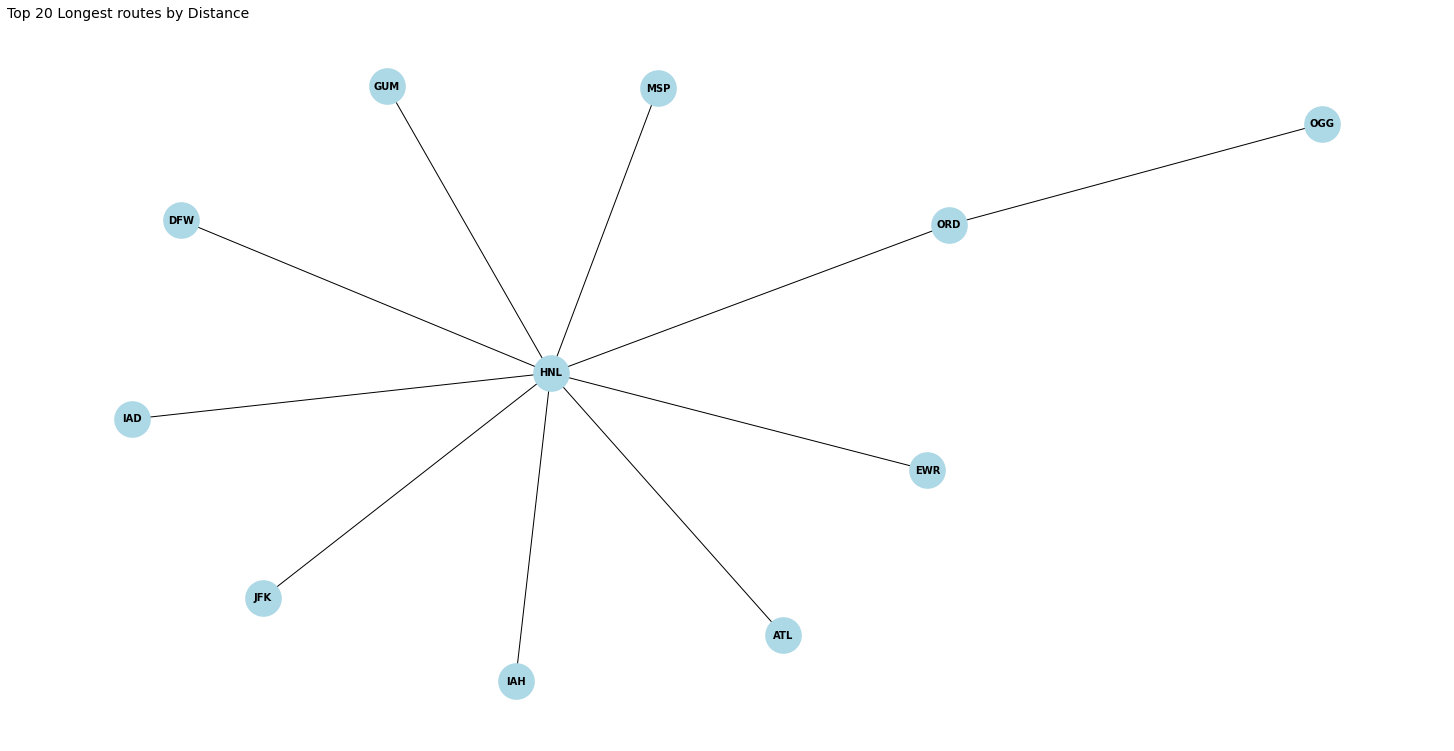

In [8]:
#Longest Air Routes
df_sub20 = data[['ORIGIN','DEST','DISTANCE']].drop_duplicates()
df_sub20 = df_sub20.sort_values('DISTANCE',ascending=False)
df_sub20 = df_sub20[['ORIGIN','DEST']]
subList20 = df_sub20.head(20).values.tolist()
subList20 = list(set(tuple(x) for x in subList20))
g20 = nx.from_edgelist(subList20)
len(g20.nodes()), len(g20.edges())

plt.figure(figsize=(20,10))
# <matplotlib.figure.Figure object at 0x7f1b65ea5e80>

nx.draw(g20, pos = nx.nx_pydot.graphviz_layout(g20), \
    node_size=1200, node_color='lightblue', linewidths=2, \
    font_size=10, font_weight='bold', with_labels=True)
plt.title("Top 20 Longest routes by Distance", fontdict=None, loc='Left', fontsize = 14)
plt.show()    ## plot2.png attached

El grafo anterior muestra las rutas más largas ¡Todas son a Hawái!

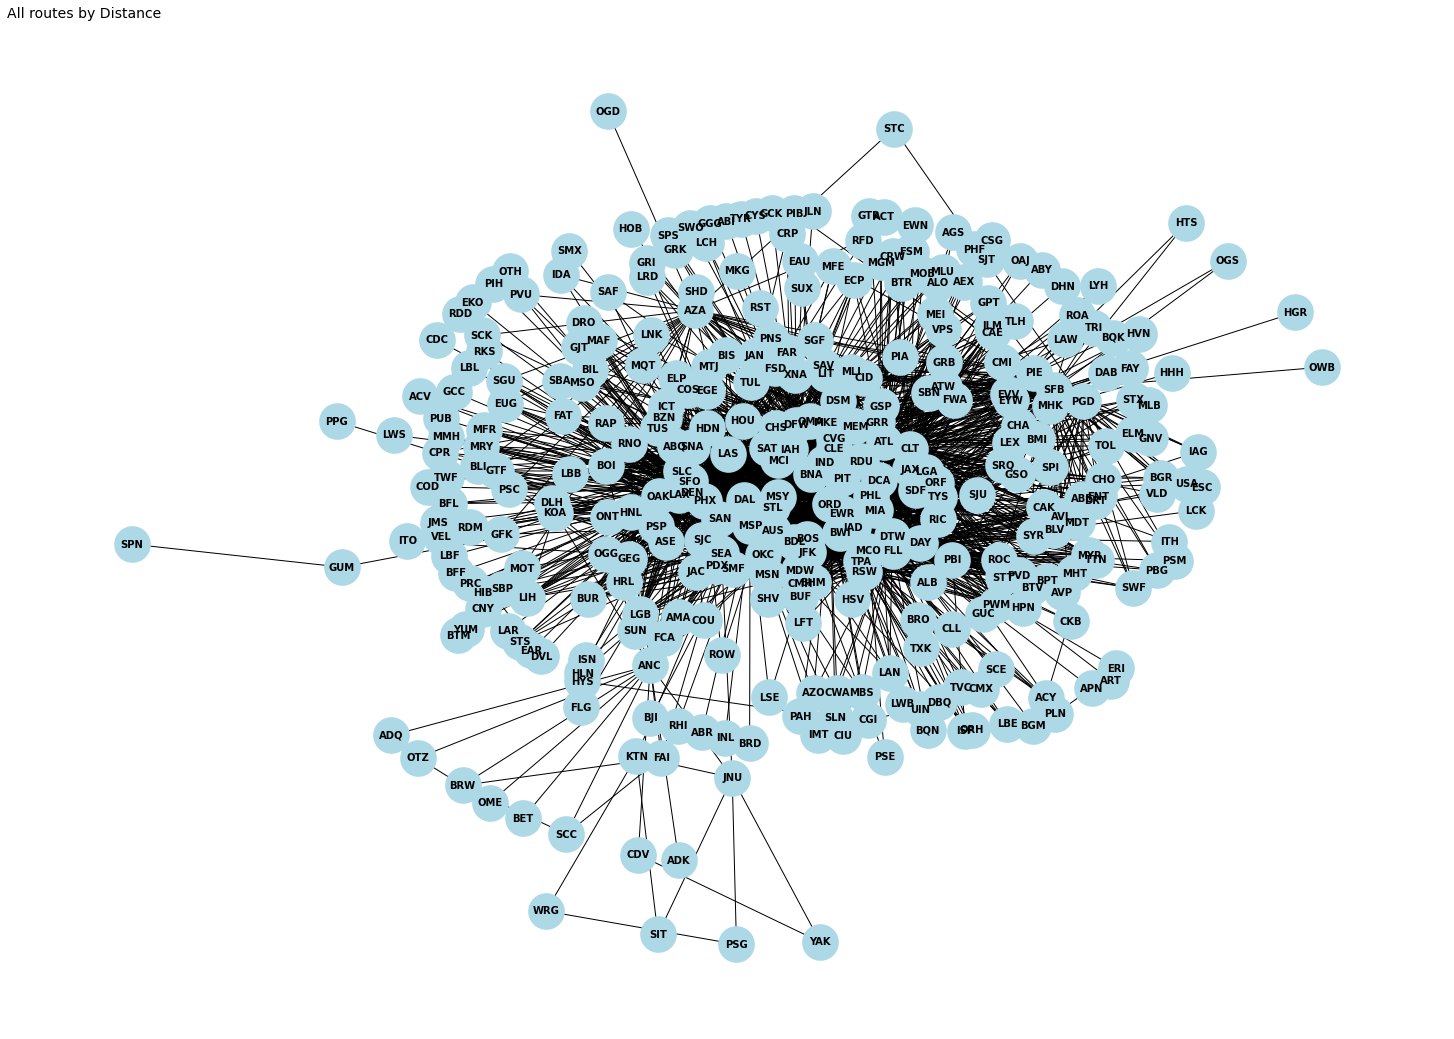

In [9]:
#All Air routes
df_sub = data[['ORIGIN','DEST']]
subList = df_sub.values.tolist()
subList = list(set(tuple(x) for x in subList))
g = nx.from_edgelist(subList)
len(g.nodes()), len(g.edges())

plt.figure(figsize=(20,14))
# <matplotlib.figure.Figure object at 0x7f1b65ea5e80>

nx.draw(g, pos = nx.nx_pydot.graphviz_layout(g), \
    node_size=1200, node_color='lightblue', linewidths=2, \
    font_size=10, font_weight='bold', with_labels=True)
plt.title("All routes by Distance", fontdict=None, loc='Left', fontsize = 14)
plt.show()    ## plot2.png attached

En la gráfica anterior podemos ver la complejidad de la red.

<AxesSubplot:>

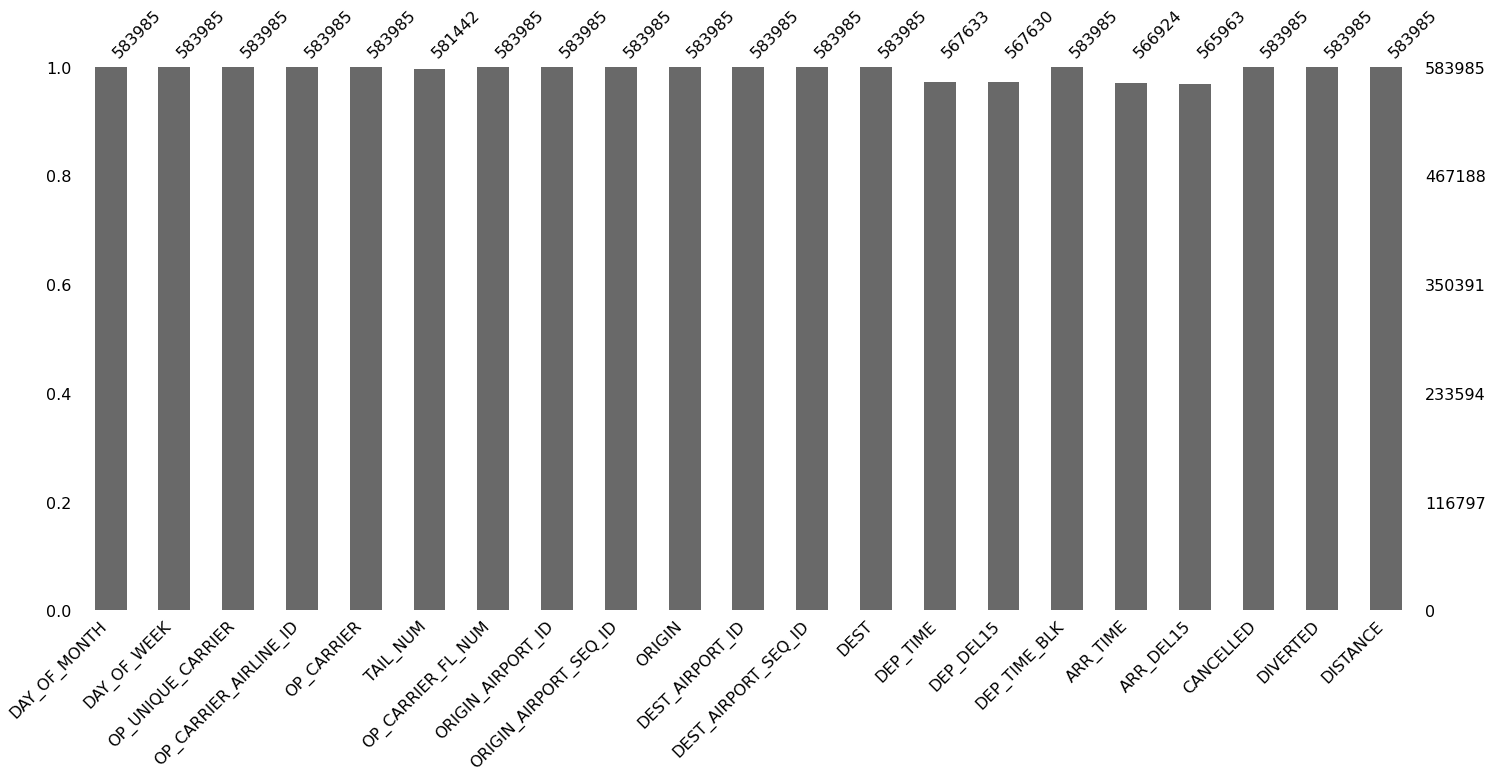

In [10]:
import missingno as msno
plt.figure(figsize=(5,5))
msno.bar(data)

En la gráfica anterior se muestran algunos valores faltantes, especialmente en las horas de salidas y llegadas. Puede ser por haya sido cancelado.

### Red Bayesiana
La aeronave que voy a utlizar es la N488HA, con lo cual especificamos, la aerolinea, las rutas y los aeropuertos para que el modelo no sea tan grande.
La hipotesis inicial, y dada los datos con la que contamos, es que conociendo el aeropuerto de origen, el aeropuerto destino y si ha sido retrasado en la salida podemos estimar efectivamente si esta retrasado en la llegada.

![primer](primer_modelo.jpg)

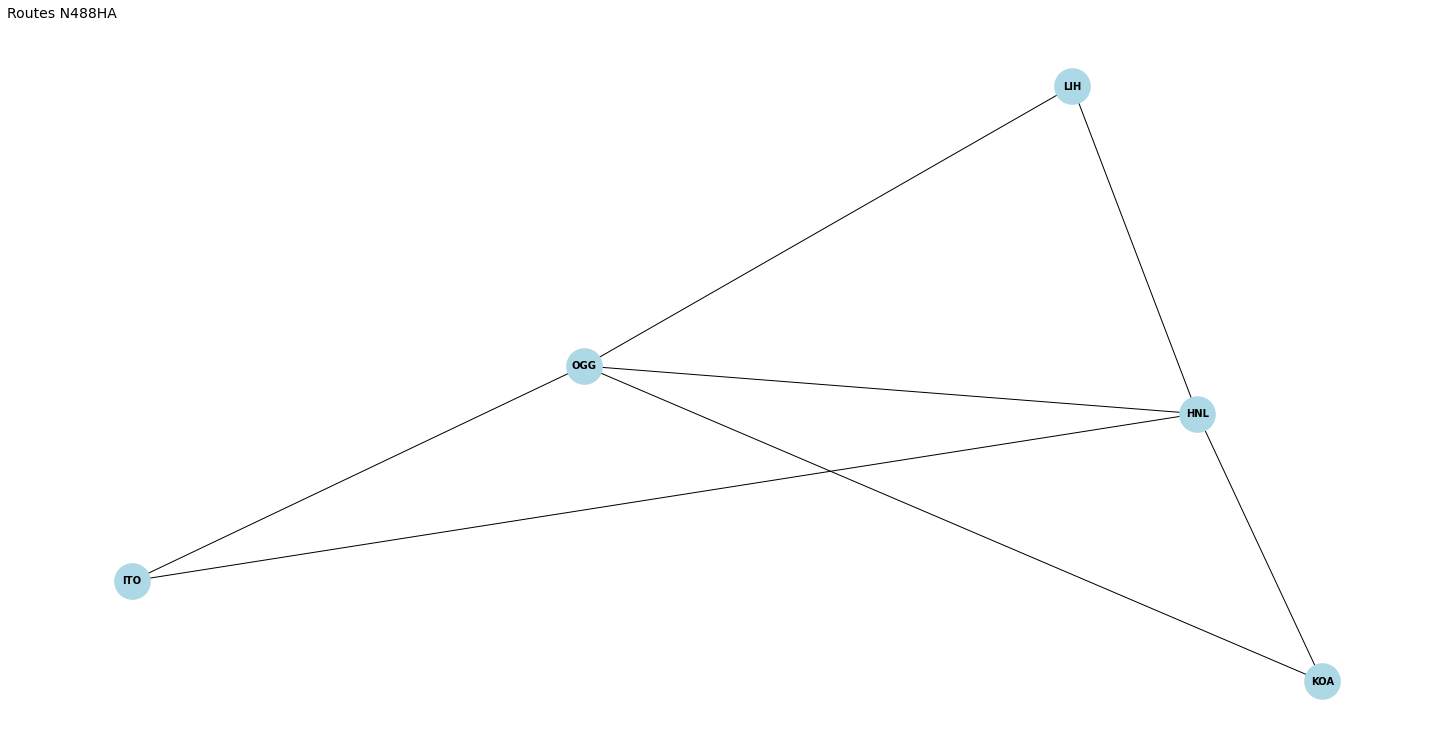

In [11]:
data_flight = data[data['TAIL_NUM'] == 'N488HA']
#data_flight = data[data['TAIL_NUM'].isin(['N488HA', 'N481HA', 'N483HA'])]
#data_flight = data.dropna(axis=0)

#Air Routes
df_sub20 = data_flight[['ORIGIN','DEST','DISTANCE']].drop_duplicates()
df_sub20 = df_sub20.sort_values('DISTANCE',ascending=False)
df_sub20 = df_sub20[['ORIGIN','DEST']]
subList20 = df_sub20.values.tolist()
subList20 = list(set(tuple(x) for x in subList20))
g20 = nx.from_edgelist(subList20)
len(g20.nodes()), len(g20.edges())

plt.figure(figsize=(20,10))

nx.draw(g20, pos = nx.nx_pydot.graphviz_layout(g20), \
    node_size=1200, node_color='lightblue', linewidths=2, \
    font_size=10, font_weight='bold', with_labels=True)
plt.title("Routes N488HA", fontdict=None, loc='Left', fontsize = 14)
plt.show()    ## plot2.png attached

variables = ['ORIGIN_AIRPORT_ID','DEST_AIRPORT_ID', 'DEP_TIME_BLK', 'DEP_DEL15', 'ARR_DEL15']
data_flight = data_flight[['ORIGIN_AIRPORT_ID','DEST_AIRPORT_ID', 'DEP_TIME_BLK', 'DEP_DEL15', 'ARR_DEL15']]

La figura muestra los viajes que hace la aeronave N488HA. La aeronave es de Hawaiian Airlines y por lo tanto es lógico que la mayoría de los vuelos sean a Hawái.

In [12]:

from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator

model = BayesianModel([
    ('ORIGIN_AIRPORT_ID', 'DEP_DEL15'),
    ('DEP_TIME_BLK', 'DEP_DEL15'),
    ('DEST_AIRPORT_ID', 'ARR_DEL15'),
    ('DEP_DEL15', 'ARR_DEL15')
])

train = data_flight.sample(frac=0.8)
test = data_flight[~data_flight.index.isin(train.index)]

model.fit(train, estimator=MaximumLikelihoodEstimator)

print(model.get_cpds('ARR_DEL15'))

+-----------------+-----+------------------------+
| DEP_DEL15       | ... | DEP_DEL15(1.0)         |
+-----------------+-----+------------------------+
| DEST_AIRPORT_ID | ... | DEST_AIRPORT_ID(13830) |
+-----------------+-----+------------------------+
| ARR_DEL15(0.0)  | ... | 0.0                    |
+-----------------+-----+------------------------+
| ARR_DEL15(1.0)  | ... | 1.0                    |
+-----------------+-----+------------------------+


c:\Users\nuno\Anaconda3\lib\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning:

BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.



In [13]:
model_pred = model.predict(test.drop(columns=['ARR_DEL15'])).values.ravel()

100%|██████████| 52/52 [00:20<00:00,  2.60it/s]



## Evaluación del modelo

Es probable que el problema especifique una métrica de evaluación inherente al modelo que prepongas. Si este no es el caso, debes proponer una métrica para evaluar tu modelo y justificar por qué es una buena métrica para el problema específico que quieres resolver.

De acuerdo a esta métrica, debes evaluar tu modelo y compararlo con otro modelo de benchmark.

Con este modelo para una aeronave los resultados de la predicción han sido del 100%.

La métrica es el porcentaje aciertos que tuvo el modelo.

Usare el modelo Naive Bayes, con las mismas variables como benchmark.

In [14]:
variables = ['ORIGIN_AIRPORT_ID','DEST_AIRPORT_ID', 'DEP_TIME_BLK', 'DEP_DEL15']
model_naive = BayesianModel([
    ('ARR_DEL15', col) for col in variables
])
model_naive.fit(train, estimator=MaximumLikelihoodEstimator)
model_naive_pred = model_naive.predict(test.drop(columns=['ARR_DEL15'])).values.ravel()

c:\Users\nuno\Anaconda3\lib\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning:

BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.

100%|██████████| 52/52 [00:00<00:00, 590.88it/s]


In [15]:
acc_bn = sum(test['ARR_DEL15'] == model_pred) / len(test) * 100
print('El modelo Bayesiana Network obtuvo resultados de ' + str(acc_bn) + '%')

El modelo Bayesiana Network obtuvo resultados de 97.22222222222221%


In [16]:
acc_navie = sum(test['ARR_DEL15'] == model_naive_pred) / len(test)*100
print('El modelo Naive Bayes obtuvo resultados de ' + str(acc_navie) + '%')

El modelo Naive Bayes obtuvo resultados de 93.05555555555556%


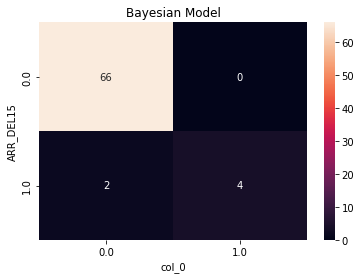

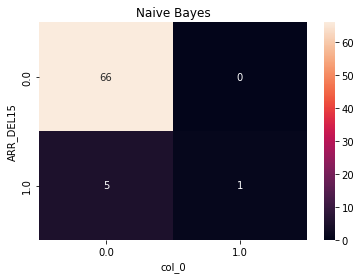

In [17]:
# Matriz de confusión
sns.heatmap(
    pd.crosstab(test['ARR_DEL15'], model_pred),
    annot=True,
)
plt.title('Bayesian Model')
plt.show()
sns.heatmap(
    pd.crosstab(test['ARR_DEL15'], model_naive_pred),
    annot=True
)
plt.title('Naive Bayes')
plt.show()

El modelo naive Bayes regresa peores resultados comparado con el modelo bayes. Aun que el modelo este sencillo regreso buenos resultados. Como ya se mencionó antes, se puede hacer una red mucho más compleja, pero para este ejercicio los resultados son favorables. Aun teniendo un modelo más complejo, por el principio de parsimonia no es conveniente ya que la mejora es marginal.

## Referencias

- Xi, N., Laskey, K., Chen, C., Williams, S., & Sherry, L. (2007). Bayesian Network Analysis of Flight Delays. Center of Air Transportation and Systems Research. https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.381.5970&rep=rep1&type=pdf

- Cao, W., & Fang, X. (2012). Airport Flight Departure Delay Model on Improved BN Structure Learning. Physics Procedia, 33. https://doi.org/10.1016/j.phpro.2012.05.109

- NASA Ames Research Center & Booz Allen Hamilton. (2020). Bayesian Networks for Departure Delay Prediction. NASA. https://humansystems.arc.nasa.gov/groups/AORG/download/Wednesday_B7_Cosmas.pdf

- Niu, X., Jiang, C., Gao, J., Korniss, G., & Szymanski, B. K. (2021). From data to complex network control of airline flight delays. Scientific Reports, 11(1). https://doi.org/10.1038/s41598-021-98112-7

- January Flight Delay Prediction. (2020, April 14). Kaggle. Retrieved July 14, 2022, from https://www.kaggle.com/datasets/divyansh22/flight-delay-prediction

- Guy, A. B. (2010, December 9). Flight delays cost $32.9 billion, passengers foot half the bill. Berkeley News. Retrieved July 12, 2022, from https://news.berkeley.edu/2010/10/18/flight_delays/

- Bloomberg. (2022, July 12). The 10 Worst Airports in Europe for Delays Right Now. https://www.bloomberg.com/news/articles/2022-07-12/worst-airports-in-europe-for-flight-delays-right-now-where-to-fly-instead